In [1]:
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'ML_Final_Project/walmart-recruiting-store-sales-forecasting'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/ML_Final_Project/walmart-recruiting-store-sales-forecasting


# Merge data

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
stores = pd.read_csv('stores.csv')
features = pd.read_csv('features.csv')

def merger(df, stores, features):
    df = df.merge(stores, how='left', on='Store')
    df = df.merge(features, how='left', on=['Store', 'Date', 'IsHoliday'])
    return df

df = merger(df, stores, features)
test = merger(test, stores, features)

df.sort_values('Date', inplace=True)
test.sort_values('Date', inplace=True)

y = df['Weekly_Sales']
X = df.drop(columns=['Weekly_Sales'])
dates = df['Date']

# print(df.head())
# print(test.head())

# Preprocessor

In [3]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.type_encoder = None  # for 'Type' column

    def fit(self, X: pd.DataFrame, y=None):
        # Fit label encoder on 'Type'
        if 'Type' in X.columns:
            self.type_encoder = X['Type'].astype('category').cat.categories
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()

        # Date features
        X['Date'] = pd.to_datetime(X['Date'])
        X['Year'] = X['Date'].dt.year
        X['Month'] = X['Date'].dt.month
        X['Day'] = X['Date'].dt.day

        # Categorical: Type
        if self.type_encoder is not None:
            X['Type'] = pd.Categorical(X['Type'], categories=self.type_encoder)
            X['Type'] = X['Type'].cat.codes

        # Convert IsHoliday to int if not already
        if 'IsHoliday' in X.columns:
            X['IsHoliday'] = X['IsHoliday'].astype(int)

        # Fill NA values
        # X = X.fillna(0)

        # Drop date column
        X = X.drop(columns=['Date'], errors='ignore')

        return X


# cross validation

In [4]:
def weighted_mae(y_true, y_pred, is_holiday):
    weights = is_holiday * 4 + 1
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

def cross_validation(pipeline, X, y, df_with_dates):
    from matplotlib.dates import DateFormatter

    tscv = TimeSeriesSplit(n_splits=8)
    rmse_scores = []
    wmae_scores = []
    train_rmse_scores = []
    train_wmae_scores = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        if fold < 4:
          continue

        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        pipeline.fit(X_train, y_train)

        # Predictions
        y_val_pred = pipeline.predict(X_val)
        y_train_pred = pipeline.predict(X_train)

        # RMSE
        val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

        # WMAE
        val_is_holiday = df_with_dates.iloc[val_idx]['IsHoliday'].astype(int)
        train_is_holiday = df_with_dates.iloc[train_idx]['IsHoliday'].astype(int)

        val_wmae = weighted_mae(y_val, y_val_pred, val_is_holiday)
        train_wmae = weighted_mae(y_train, y_train_pred, train_is_holiday)

        print(f"\nFold {fold + 1} Scores:")
        print(f"Train RMSE: {train_rmse:.2f} | Train WMAE: {train_wmae:.2f}")
        print(f"Valid RMSE: {val_rmse:.2f} | Valid WMAE: {val_wmae:.2f}")

        rmse_scores.append(val_rmse)
        wmae_scores.append(val_wmae)
        train_rmse_scores.append(train_rmse)
        train_wmae_scores.append(train_wmae)

        # --- Plotting ---
        df_all = pd.DataFrame({
            'Date': pd.to_datetime(df_with_dates['Date']),
            'y': y.values
        })
        df_all = df_all.groupby('Date').sum().reset_index().sort_values('Date')

        df_val = pd.DataFrame({
            'Date': pd.to_datetime(df_with_dates.iloc[val_idx]['Date']),
            'Actual': y_val.values,
            'Predicted': y_val_pred
        }).groupby('Date').sum().reset_index().sort_values('Date')

        df_train = pd.DataFrame({
            'Date': pd.to_datetime(df_with_dates.iloc[train_idx]['Date']),
            'Actual': y_train.values,
            'Predicted': y_train_pred
        }).groupby('Date').sum().reset_index().sort_values('Date')

        plt.figure(figsize=(12, 4))

        # Train actuals
        plt.plot(df_all['Date'], df_all['y'], color='gray', label='Train Actuals', linewidth=1.5, alpha=0.4)

        # Train predictions
        plt.plot(df_train['Date'], df_train['Predicted'], color='green', label='Train Predicted', linewidth=1.5, alpha=0.8)

        # Validation actuals
        plt.plot(df_val['Date'], df_val['Actual'], color='blue', label='Val Actuals', linewidth=2)

        # Validation predictions
        plt.plot(df_val['Date'], df_val['Predicted'], color='orange', label='Val Predicted', linewidth=2)

        plt.title(f'Fold {fold + 1} - Weekly Sales Over Time', fontsize=14)
        plt.xlabel("Date")
        plt.ylabel("Weekly Sales")
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

    # --- Averages ---
    print(f"\nMean Train RMSE: {np.mean(train_rmse_scores):.2f}")
    print(f"Mean Train WMAE: {np.mean(train_wmae_scores):.2f}")
    print(f"Mean Valid RMSE: {np.mean(rmse_scores):.2f}")
    print(f"Mean Valid WMAE: {np.mean(wmae_scores):.2f}")


# Pipeline


Fold 5 Scores:
Train RMSE: 5450.84 | Train WMAE: 3136.76
Valid RMSE: 6894.95 | Valid WMAE: 3982.90


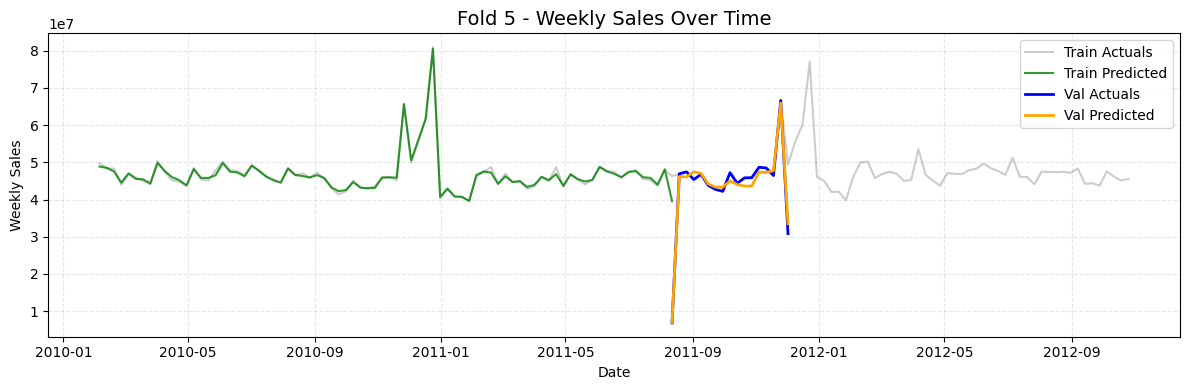


Fold 6 Scores:
Train RMSE: 5847.37 | Train WMAE: 3351.68
Valid RMSE: 7089.08 | Valid WMAE: 3808.96


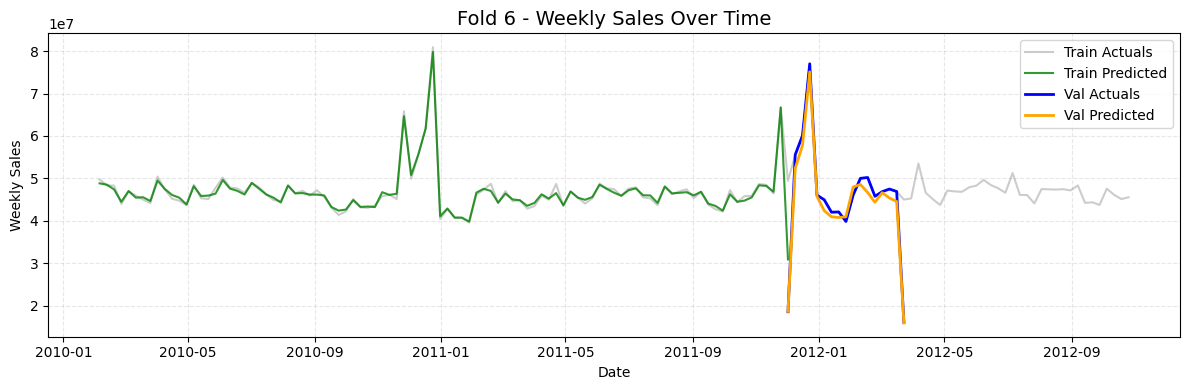


Fold 7 Scores:
Train RMSE: 5980.19 | Train WMAE: 3396.36
Valid RMSE: 5888.02 | Valid WMAE: 3496.46


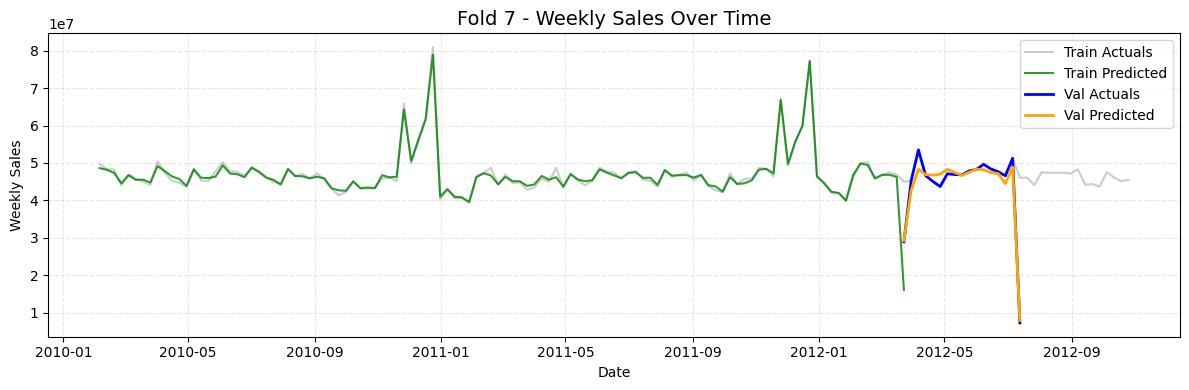


Fold 8 Scores:
Train RMSE: 5971.06 | Train WMAE: 3422.31
Valid RMSE: 5449.39 | Valid WMAE: 3349.57


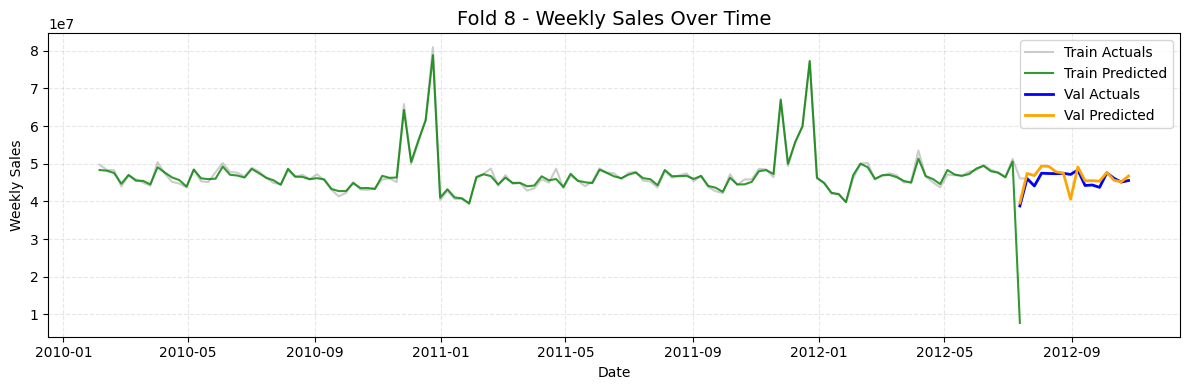


Mean Train RMSE: 5812.36
Mean Train WMAE: 3326.78
Mean Valid RMSE: 6330.36
Mean Valid WMAE: 3659.47


In [6]:
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

preprocessor = Preprocessor()
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=10,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    n_jobs=-1,
    random_state=42
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

cross_validation(pipeline, X, y, df)

In [7]:
pipeline.fit(X, y)

Pipeline(steps=[('preprocessor', Preprocessor()),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.8, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=1, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None, min_child_weight=10,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=500, n_jobs=-1,
                              num_parallel_tree=None, random_state=42, ...))])